In [46]:
import matplotlib.pyplot as plt
from data_setup import create_dataloaders
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
from pathlib import Path
import torch
import torch_geometric
import networkx as nx
import numpy as np
from models import GCNClassifier, GATClassifier, GINConvClassifier, GINEConvClassifier, GraphConvClassifier, MODIFIED_GINEConvClassifier
from torch_geometric.nn import global_mean_pool
from sklearn.metrics import  ConfusionMatrixDisplay, roc_auc_score, classification_report, confusion_matrix
from utils import new_metric_func, average_model_metrics, plot_average_metrics, loss_acc_auc_plots
import pickle
from sklearn.manifold import TSNE
import datetime


In [2]:
device  = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
project_path = Path("/home/louis/Documents/personal_coding/graph_neural_networks/drug_discovery_with_bace_dataset/")
data_path = project_path / "data"
bace_path = data_path / "raw"
bace_models_path = project_path/ "models"

In [4]:
bace_df = pd.read_csv(bace_path/ "bace.csv")
bace_df["Class"].value_counts()

0    822
1    691
Name: Class, dtype: int64

In [5]:
dataset, train_dataset, test_dataset, train_dataloader, test_dataloader = create_dataloaders(root_directory = "/home/louis/Documents/personal_coding/graph_neural_networks/drug_discovery_with_bace_dataset/data/",
                                                                batch_size = 32, shuffled_indices_path  = "/home/louis/Documents/personal_coding/graph_neural_networks/drug_discovery_with_bace_dataset/data/dataset_indices_list")

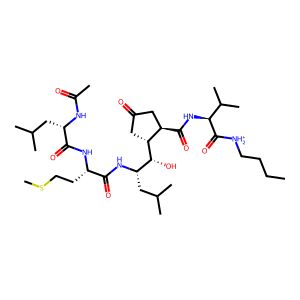

In [6]:
inhibitor = dataset[30]["smiles"]

m = Chem.MolFromSmiles(inhibitor)

img = Draw.MolToImage(m)

display(img)

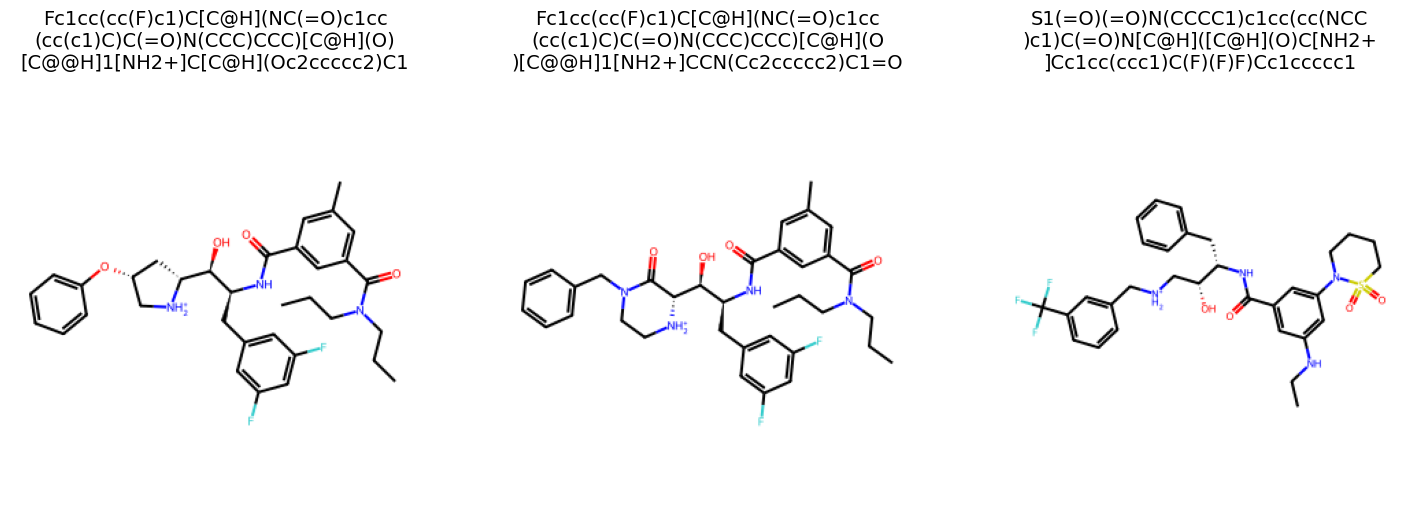

In [7]:
# Display five random molecules with their SMILES molecules

# Create axes and sample SMILES molecules
fig, ax = plt.subplots(ncols=3, nrows=1, figsize = (18,6))
# mols = bace_df.sample(n=5, random_state=42)["mol"]
x=10
mols = dataset[x:x+3]

for i in range(len(mols)):

  # Convert each molecule to an image
  mol = mols[i]["smiles"]
  m = Chem.MolFromSmiles(mol)
  img = Draw.MolToImage(m)

  # Plot each molecule
  ax[i].imshow(img)
  ax[i].axis(False);

  # Divide the SMILE input into three parts
  first_part = mol[:int(len(mol)/3)]
  second_part = mol[int(len(mol)//3):int(2*len(mol)//3)]
  third_part = mol[int(2*len(mol)//3):]

  assert len(mol) == len(first_part)+len(second_part)+len(third_part)

  first_title = first_part + "\n"
  second_title = second_part + "\n"
  third_title = third_part + "\n"

  # Title each plot with its respective SMILE input
  ax[i].set_title(first_title+second_title+third_title, fontsize=14)

In [8]:
def count_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol.GetNumAtoms() if mol else 0
total_atoms = 0

for i in range(len(dataset)): 
    total_atoms += count_atoms(dataset[i]["smiles"])
    

In [9]:
total_atoms/len(dataset)

34.08922670191672

In [10]:
# Load a single graph

print(f"Number of nodes in graph is: {dataset[0].x.shape[0]}")
print(f"Number of features for each node is {dataset[0].num_features}")
print(f"Number of edges is {dataset[0].edge_index.shape[1]}")
print(f"Data object is {dataset[0]}\n")

Number of nodes in graph is: 32
Number of features for each node is 30
Number of edges is 70
Data object is Data(x=[32, 30], edge_index=[2, 70], edge_attr=[70, 11], Class=[1], smiles='O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C', pic50=9.1549015)



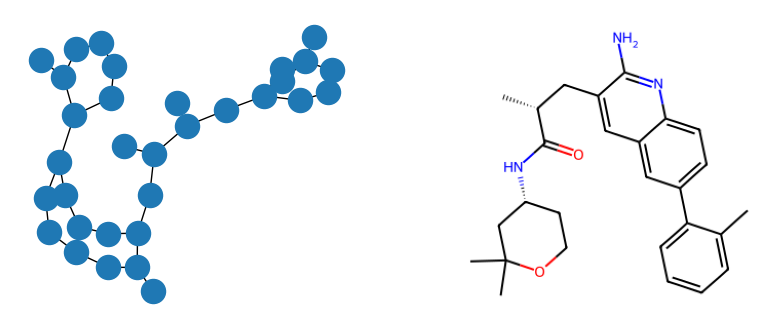

In [11]:
np.random.seed(41)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (10,4))

g = torch_geometric.utils.to_networkx(dataset[0], to_undirected=True)
nx.draw(g, ax = ax[0])

mol = dataset[0].smiles
m = Chem.MolFromSmiles(mol)
img = Draw.MolToImage(m)

ax[1].imshow(img)
ax[1].axis(False);

In [12]:
print(train_dataset.indices())
print(test_dataset.indices())

[812, 780, 1275, 897, 196, 1108, 845, 477, 1233, 1474, 581, 269, 1022, 967, 1031, 661, 1215, 1472, 150, 311, 281, 1509, 848, 1444, 84, 230, 571, 1296, 515, 1004, 190, 199, 511, 762, 642, 347, 971, 1005, 495, 1071, 252, 103, 36, 412, 994, 1312, 654, 777, 1121, 1494, 877, 1074, 1493, 1192, 530, 644, 1375, 1441, 711, 63, 746, 1339, 450, 1073, 1252, 1066, 299, 797, 23, 938, 429, 250, 741, 386, 1342, 734, 154, 1416, 336, 1044, 451, 172, 47, 1446, 513, 675, 828, 1331, 93, 794, 1129, 876, 912, 142, 374, 964, 659, 140, 194, 1295, 116, 706, 399, 528, 577, 690, 1450, 1196, 303, 175, 878, 1159, 817, 534, 976, 1290, 1177, 206, 1009, 233, 482, 197, 115, 339, 617, 808, 1512, 85, 977, 724, 899, 1245, 388, 953, 504, 109, 279, 929, 748, 1139, 468, 1425, 1206, 332, 923, 1455, 552, 1297, 1421, 1056, 280, 1113, 957, 851, 1255, 1382, 802, 662, 398, 1072, 312, 1321, 3, 310, 575, 137, 879, 637, 1440, 678, 158, 209, 781, 55, 186, 632, 960, 235, 1141, 663, 640, 1491, 1484, 593, 1214, 541, 728, 1033, 684, 826, 

Model parameters saved at epochs:
84
87
107
94
49


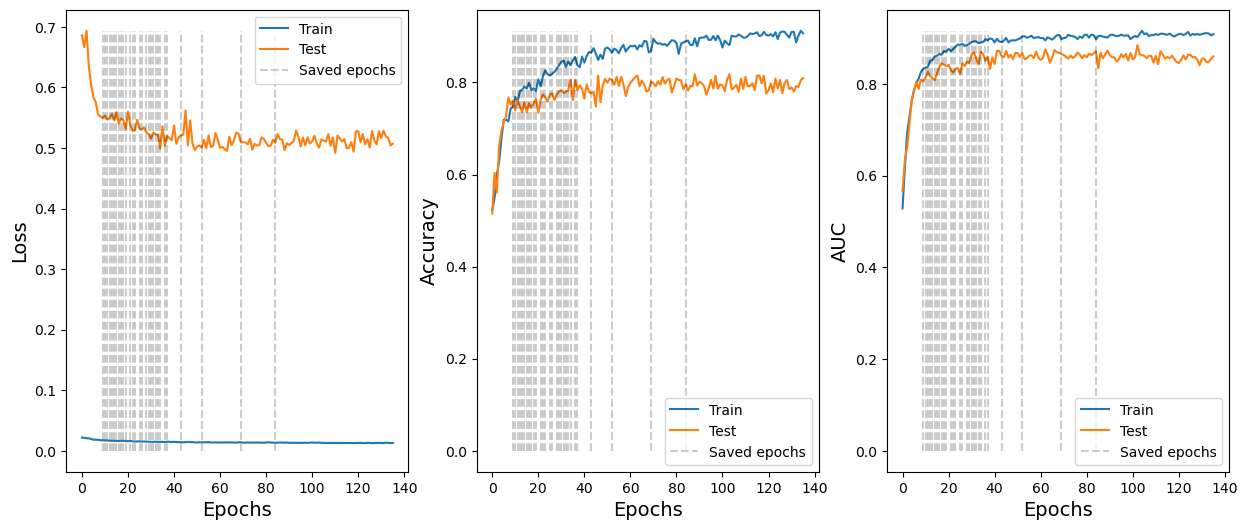

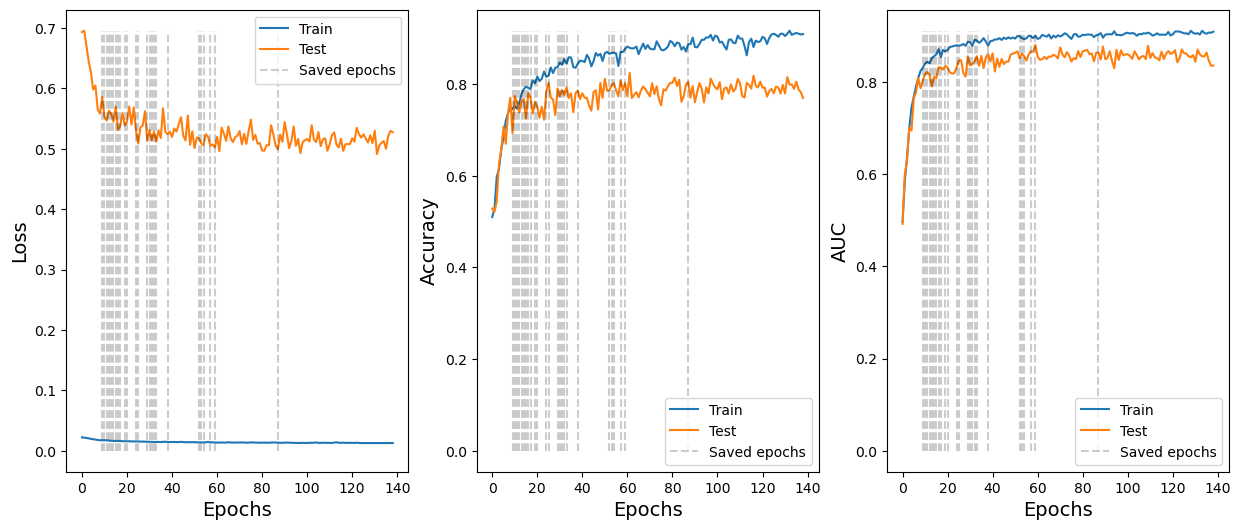

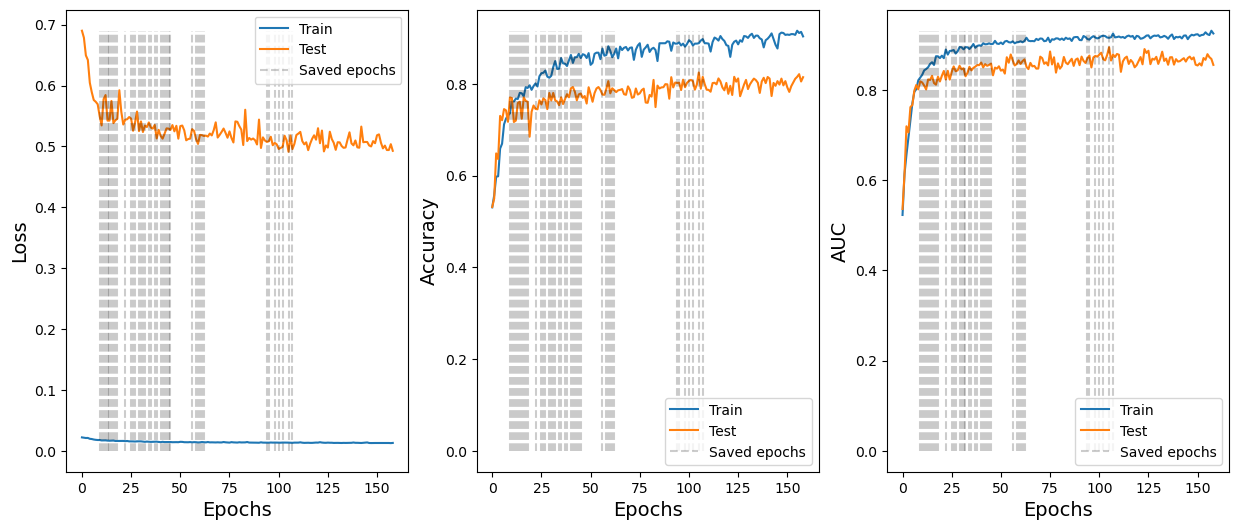

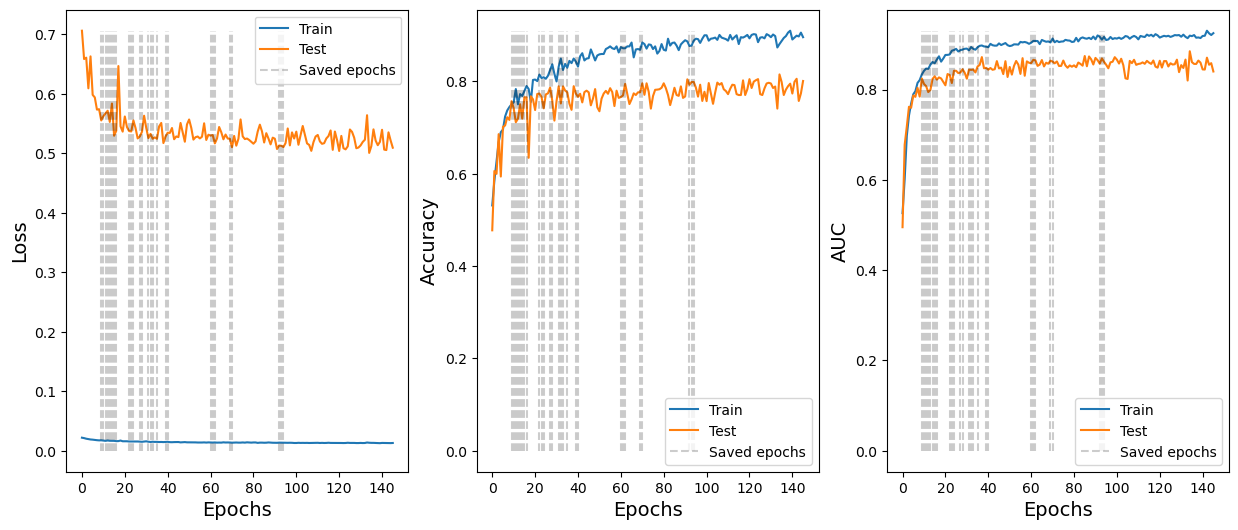

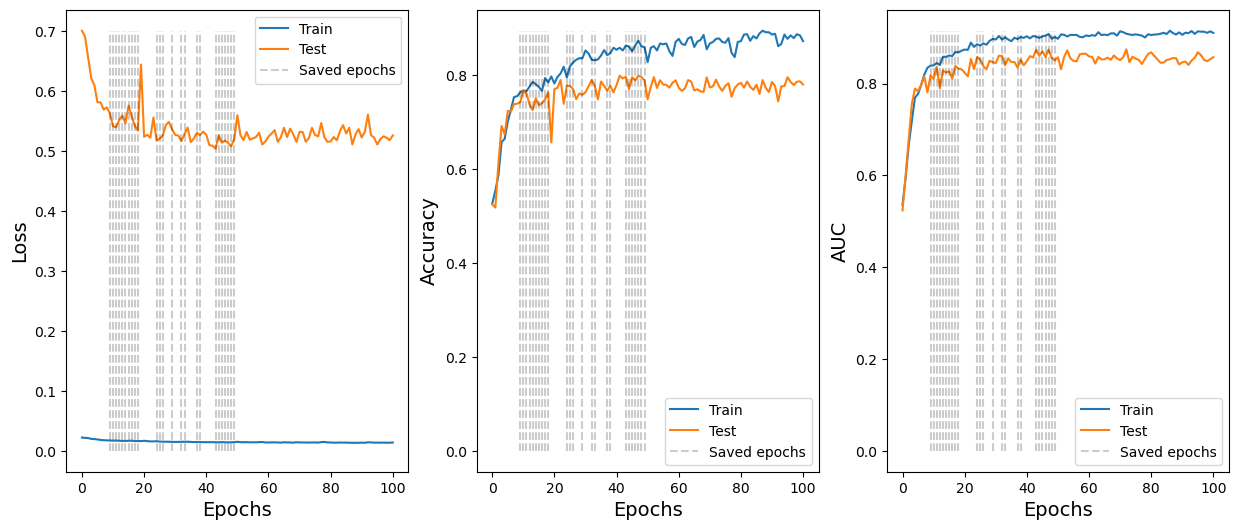

In [13]:
print("Model parameters saved at epochs:")
for i in range(0,5):
  with open(f'/home/louis/Documents/personal_coding/graph_neural_networks/drug_discovery_with_bace_dataset/models/graphconv_models/{i}_128_300_global_mean_pool_results.pkl', 'rb') as func:
      loaded_dict = pickle.load(func)
  print(loaded_dict["saved_epochs"][-1])

  loss_acc_auc_plots(loaded_dict)

In [14]:
# Load a random GCN model to try new_metric_func on 
bace_gcn_models_path =  bace_models_path / "gcn_models"
model_save_path = bace_gcn_models_path/"0_128_300_global_mean_pool.pth"

loaded_model = GCNClassifier(30, 128, 2, global_mean_pool)



if torch.cuda.is_available():
  loaded_model.load_state_dict(torch.load(f=model_save_path))
else:
  loaded_model.load_state_dict(torch.load(f=model_save_path, map_location=torch.device('cpu')))

  loaded_model.eval()


0.8836 0.8071
Train Classification Report:


,precision,recall,f1-score,support
0.0,0.889968,0.832073,0.860047,661.000000
1.0,0.812500,0.876138,0.843120,549.000000
accuracy,0.852066,0.852066,0.852066,0.852066
macro avg,0.851234,0.854106,0.851583,1210.000000
weighted avg,0.854819,0.852066,0.852367,1210.000000


Test Classification Report:


,precision,recall,f1-score,support
0.0,0.797468,0.782609,0.789969,161.000000
1.0,0.758621,0.774648,0.766551,142.000000
accuracy,0.778878,0.778878,0.778878,0.778878
macro avg,0.778045,0.778628,0.778260,303.000000
weighted avg,0.779263,0.778878,0.778994,303.000000


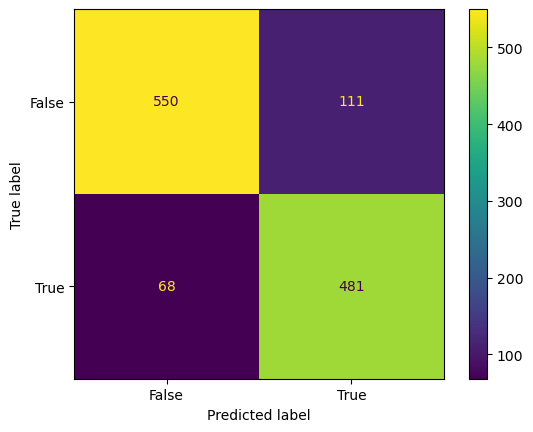

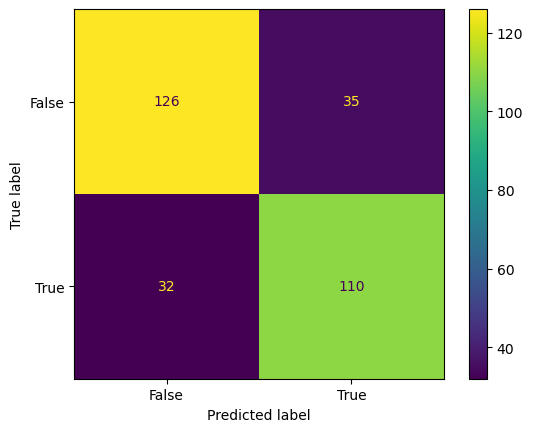

In [15]:

torch.manual_seed(42)
loaded_model = loaded_model.to(device)

train_auroc, test_auroc, train_classification_report, test_classification_report, train_confusion_matrix, test_confusion_matrix = new_metric_func(loaded_model, train_dataloader, test_dataloader, threshold=0.5)
print(round(train_auroc,4), round(test_auroc, 4))

print("Train Classification Report:")
display(train_classification_report)
print("Test Classification Report:")
display(test_classification_report)

cm_display_train = ConfusionMatrixDisplay(confusion_matrix = train_confusion_matrix, display_labels = ([False, True]))
cm_display_train.plot()

cm_display_test = ConfusionMatrixDisplay(confusion_matrix = test_confusion_matrix, display_labels = ([False, True]))
cm_display_test.plot()


In [16]:
# Load a random GINEConv model to try new_metric_func on 
torch.manual_seed(42)

new_bace_gineconv_models_path = bace_models_path / "new_gineconv_models"
model_save_path = new_bace_gineconv_models_path/"0_128_300_0.0001_global_mean_pool.pth"

gine_loaded_model = GINEConvClassifier(30, 128, 2, 3, global_mean_pool, True, 11)



if torch.cuda.is_available():
  gine_loaded_model.load_state_dict(torch.load(f=model_save_path))
  gine_loaded_model.eval()
else:
  gine_loaded_model.load_state_dict(torch.load(f=model_save_path, map_location=torch.device('cpu')))
  gine_loaded_model.eval()


gine_loaded_model = gine_loaded_model.to(device)


0.9347 0.8815
Train Classification Report:


,precision,recall,f1-score,support
0.0,0.880355,0.901664,0.890882,661.000000
1.0,0.878049,0.852459,0.865065,549.000000
accuracy,0.879339,0.879339,0.879339,0.879339
macro avg,0.879202,0.877062,0.877973,1210.000000
weighted avg,0.879308,0.879339,0.879168,1210.000000


Test Classification Report:


,precision,recall,f1-score,support
0.0,0.805714,0.875776,0.839286,161.000000
1.0,0.843750,0.760563,0.800000,142.000000
accuracy,0.821782,0.821782,0.821782,0.821782
macro avg,0.824732,0.818170,0.819643,303.000000
weighted avg,0.823540,0.821782,0.820875,303.000000


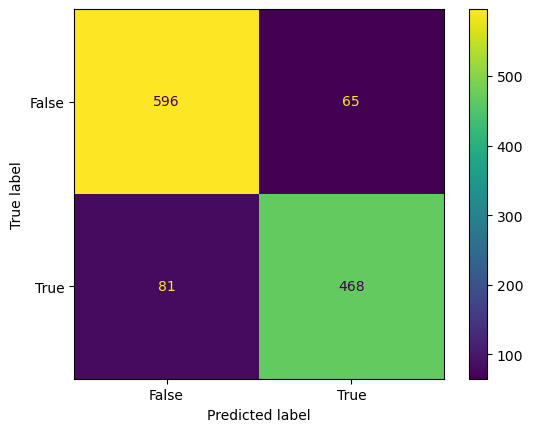

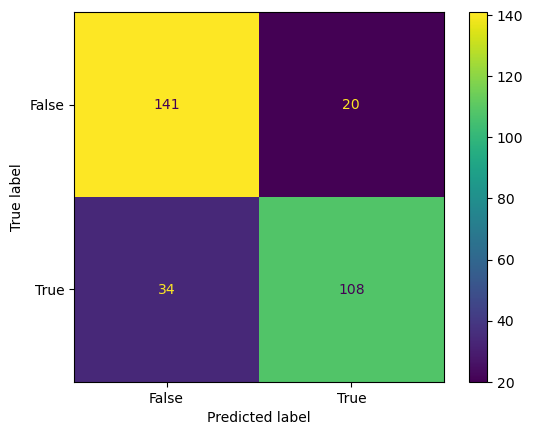

In [17]:

torch.manual_seed(42)

train_auroc, test_auroc, train_classification_report, test_classification_report, train_confusion_matrix, test_confusion_matrix = new_metric_func(gine_loaded_model, train_dataloader, test_dataloader, threshold=0.5)
print(round(train_auroc,4), round(test_auroc, 4))

print("Train Classification Report:")
display(train_classification_report)
print("Test Classification Report:")
display(test_classification_report)

cm_display_train = ConfusionMatrixDisplay(confusion_matrix = train_confusion_matrix, display_labels = ([False, True]))
cm_display_train.plot()

cm_display_test = ConfusionMatrixDisplay(confusion_matrix = test_confusion_matrix, display_labels = ([False, True]))
cm_display_test.plot()

Average Train Confusion Matrix:


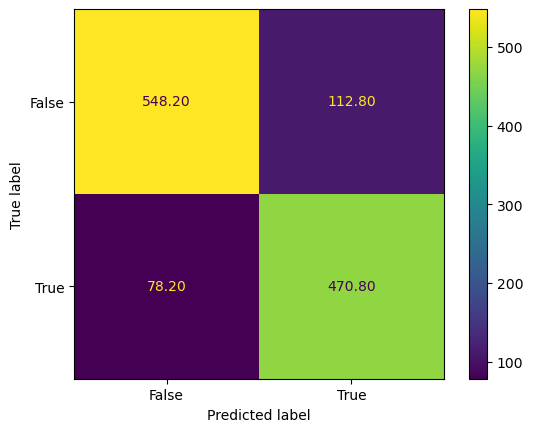

Average Test Confusion Matrix:


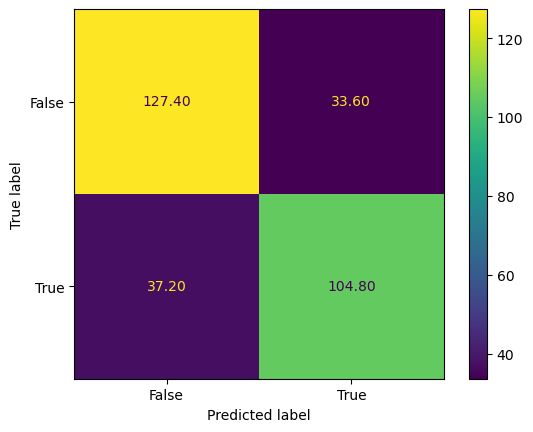

In [18]:
# Define the path to GCN models
bace_gcn_models_path = bace_models_path / "gcn_models"
model_names = [f"{i}_128_300_global_mean_pool.pth" for i in range(5)]

# Initialize variables to store cumulative confusion matrices
cumulative_train_conf_matrix = np.zeros((2, 2), dtype=int)
cumulative_test_conf_matrix = np.zeros((2, 2), dtype=int)

# Loop through each model
for model_name in model_names:
    model_save_path = bace_gcn_models_path / model_name

    # Load model
    loaded_model = GCNClassifier(30, 128, 2, global_mean_pool)
    
    if torch.cuda.is_available():
        loaded_model.load_state_dict(torch.load(f=model_save_path))
    else:
        loaded_model.load_state_dict(torch.load(f=model_save_path, map_location=torch.device('cpu')))
        
    loaded_model.eval()
    torch.manual_seed(42)
    loaded_model = loaded_model.to(device)
    
    # Calculate metrics
    train_auroc, test_auroc, train_classification_report, test_classification_report, train_confusion_matrix, test_confusion_matrix = new_metric_func(
        loaded_model, train_dataloader, test_dataloader, threshold=0.5
    )
    
    # Add confusion matrices
    cumulative_train_conf_matrix += train_confusion_matrix
    cumulative_test_conf_matrix += test_confusion_matrix

# Calculate the average confusion matrix
average_train_conf_matrix = cumulative_train_conf_matrix / len(model_names)
average_test_conf_matrix = cumulative_test_conf_matrix / len(model_names)

# Display the average confusion matrix for the training set
print("Average Train Confusion Matrix:")
cm_display_train = ConfusionMatrixDisplay(confusion_matrix=average_train_conf_matrix, display_labels=([False, True]))
cm_display_train.plot(cmap='viridis', values_format='.2f')  # '.2f' will display values as floating-point numbers with 2 decimal places
plt.show()

# Display the average confusion matrix for the test set
print("Average Test Confusion Matrix:")
cm_display_test = ConfusionMatrixDisplay(confusion_matrix=average_test_conf_matrix, display_labels=([False, True]))
cm_display_test.plot(cmap='viridis', values_format='.2f')  # '.2f' will display values as floating-point numbers with 2 decimal places
plt.show()

Average Train Confusion Matrix:


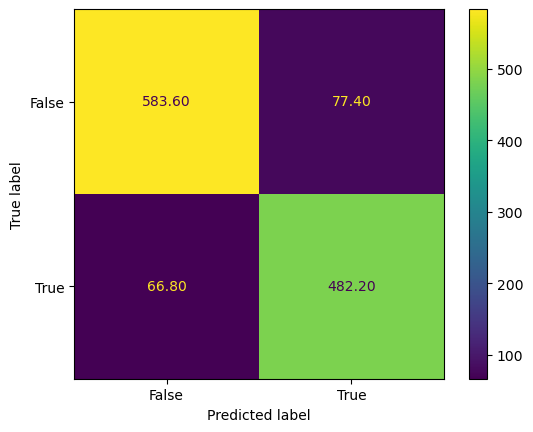

Average Test Confusion Matrix:


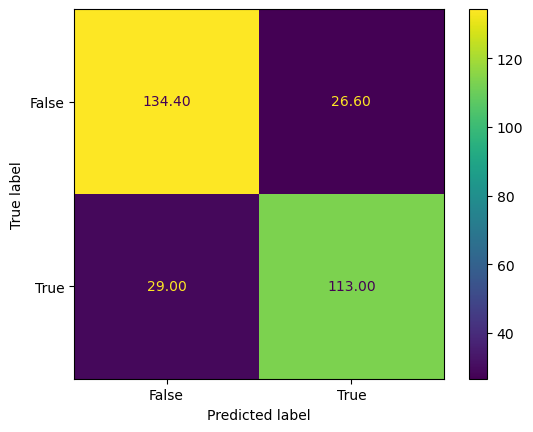

In [19]:
# Define the path to GCN models

new_bace_gineconv_models_path = bace_models_path / "new_gineconv_models"
model_names = [f"{i}_128_300_0.0001_global_mean_pool.pth" for i in range(5)]


# Initialize variables to store cumulative confusion matrices
cumulative_train_conf_matrix = np.zeros((2, 2), dtype=int)
cumulative_test_conf_matrix = np.zeros((2, 2), dtype=int)

# Loop through each model
for model_name in model_names:
    model_save_path = new_bace_gineconv_models_path / model_name

    # Load model
    gine_loaded_model = GINEConvClassifier(30, 128, 2, 3, global_mean_pool, True, 11)
    
    if torch.cuda.is_available():
        gine_loaded_model.load_state_dict(torch.load(f=model_save_path))
    else:
        gine_loaded_model.load_state_dict(torch.load(f=model_save_path, map_location=torch.device('cpu')))
        
    gine_loaded_model.eval()
    torch.manual_seed(42)
    gine_loaded_model = gine_loaded_model.to(device)
    
    # Calculate metrics
    train_auroc, test_auroc, train_classification_report, test_classification_report, train_confusion_matrix, test_confusion_matrix = new_metric_func(
        gine_loaded_model, train_dataloader, test_dataloader, threshold=0.5
    )
    
    # Add confusion matrices
    cumulative_train_conf_matrix += train_confusion_matrix
    cumulative_test_conf_matrix += test_confusion_matrix

# Calculate the average confusion matrix
average_train_conf_matrix = cumulative_train_conf_matrix / len(model_names)
average_test_conf_matrix = cumulative_test_conf_matrix / len(model_names)

# Display the average confusion matrix for the training set
print("Average Train Confusion Matrix:")
cm_display_train = ConfusionMatrixDisplay(confusion_matrix=average_train_conf_matrix, display_labels=([False, True]))
cm_display_train.plot(cmap='viridis', values_format='.2f')  # '.2f' will display values as floating-point numbers with 2 decimal places
plt.show()

# Display the average confusion matrix for the test set
print("Average Test Confusion Matrix:")
cm_display_test = ConfusionMatrixDisplay(confusion_matrix=average_test_conf_matrix, display_labels=([False, True]))
cm_display_test.plot(cmap='viridis', values_format='.2f')  # '.2f' will display values as floating-point numbers with 2 decimal places
plt.show()

In [20]:
num_features = 30
num_hidden_channels = 128
num_out_channels = 2
heads = 4
num_layers = 3
edge_dim = 11
pool_method = global_mean_pool
use_edge_attr = True
nb_repeats = 5

gcn_model_skeleton = GCNClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)
gat_model_skeleton = GATClassifier(num_features, num_hidden_channels, num_out_channels, heads, pool_method, False)
graphconv_model_skeleton = GraphConvClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)
ginconv_model_skeleton = GINConvClassifier(num_features, num_hidden_channels, num_out_channels, num_layers, pool_method)
gineconv_model_skeleton = GINEConvClassifier(num_features, num_hidden_channels, num_out_channels, num_layers, pool_method, use_edge_attr, edge_dim)
gate_model_skeleton = GATClassifier(num_features, num_hidden_channels, num_out_channels, heads, pool_method, True)

bace_gcn_models_path = bace_models_path / "gcn_models"
bace_gat_models_path = bace_models_path / "gat_models"
bace_graphconv_models_path = bace_models_path / "graphconv_models"
bace_ginconv_models_path = bace_models_path / "ginconv_models"
bace_gineconv_models_path = bace_models_path / "gineconv_models"
bace_gat_edge_models_path = bace_models_path / "gat_edge_models"
new_bace_ginconv_models_path = bace_models_path / "new_ginconv_models"
new_bace_gineconv_models_path = bace_models_path / "new_gineconv_models"

save_yes_no = True
auroc_df, mean_train_model_metrics, mean_test_model_metrics, std_train_model_metrics, std_test_model_metrics = average_model_metrics(ginconv_model_skeleton, new_bace_ginconv_models_path, "_128_300_0.0001_global_mean_pool.pth", nb_repeats, save_yes_no, train_dataloader, test_dataloader, 128, 300, global_mean_pool, threshold=0.5)
print("Area under the curve metrics")
display(auroc_df)
print(f"Mean Train metrics from {nb_repeats} repeats")
display(mean_train_model_metrics)
print(f"Mean Test metrics from {nb_repeats} repeats")
display(mean_test_model_metrics)
print(f"Standard Deviation of train metrics from {nb_repeats} repeats") 
display(std_train_model_metrics)
print(f"Standard Deviation of test metrics from {nb_repeats} repeats")
display(std_test_model_metrics)

Saved auroc dataframe
Saved mean train metrics
Saved mean test metrics
Saved std train metrics
Saved std test metrics
Area under the curve metrics


,Train,Test
0,0.926158,0.877198
1,0.002212,0.003814


Mean Train metrics from 5 repeats


,precision,recall,f1-score,support
0.0,0.916401,0.871710,0.893153,661.000000
1.0,0.854579,0.903461,0.877982,549.000000
accuracy,0.886116,0.886116,0.886116,0.886116
macro avg,0.885490,0.887585,0.885567,1210.000000
weighted avg,0.888351,0.886116,0.886269,1210.000000


Mean Test metrics from 5 repeats


,precision,recall,f1-score,support
0.0,0.834881,0.822360,0.828515,161.000000
1.0,0.802060,0.815493,0.808653,142.000000
accuracy,0.819142,0.819142,0.819142,0.819142
macro avg,0.818471,0.818927,0.818584,303.000000
weighted avg,0.819500,0.819142,0.819207,303.000000


Standard Deviation of train metrics from 5 repeats


,precision,recall,f1-score,support
0.0,0.018917,0.020919,0.004600,0.000000
1.0,0.016327,0.024708,0.005215,0.000000
accuracy,0.004149,0.004149,0.004149,0.004149
macro avg,0.004255,0.004572,0.004181,0.000000
weighted avg,0.004985,0.004149,0.004154,0.000000


Standard Deviation of test metrics from 5 repeats


,precision,recall,f1-score,support
0.0,0.012811,0.015590,0.012024,0.000000
1.0,0.015004,0.016059,0.013160,0.000000
accuracy,0.012437,0.012437,0.012437,0.012437
macro avg,0.012452,0.012440,0.012463,0.000000
weighted avg,0.012381,0.012437,0.012428,0.000000


In [21]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def threshold_metrics(thresholds, model_skeleton, model_path, save_true_false=False):
    precision_thresholds = []
    recall_thresholds = []
    for i in thresholds:
        auroc_df, mean_train_model_metrics, mean_test_model_metrics, std_train_model_metrics, std_test_model_metrics = average_model_metrics(model_skeleton, model_path, "_128_300_0.0001_global_mean_pool.pth", nb_repeats, save_yes_no, train_dataloader, test_dataloader, 128, 300, global_mean_pool, threshold=i)
        precision_thresholds.append(mean_test_model_metrics["precision"].loc["1.0"])
        recall_thresholds.append(mean_test_model_metrics["recall"].loc["1.0"])
    threshold_dict = {"thresholds": thresholds, "precision thresholds" : precision_thresholds, "recall thresholds": recall_thresholds}
    threshold_df = pd.DataFrame(threshold_dict)

    if save_true_false:                                                                                                                     
        threshold_df.to_pickle(model_path/'precision_recall_thresholds_distribution.pkl')


    return threshold_df

# gcn_threshold_metrics_df  = threshold_metrics(thresholds, gcn_model_skeleton, bace_gcn_models_path, save_true_false=True)
# gineconv_threshold_metrics_df  = threshold_metrics(thresholds, gineconv_model_skeleton, new_bace_gineconv_models_path, save_true_false=True)

In [22]:
gcn_threshold_metrics_df = pd.read_pickle("/home/louis/Documents/personal_coding/graph_neural_networks/drug_discovery_with_bace_dataset/models/gcn_models/precision_recall_thresholds_distribution.pkl")
gineconv_threshold_metrics_df = pd.read_pickle("/home/louis/Documents/personal_coding/graph_neural_networks/drug_discovery_with_bace_dataset/models/gineconv_models/precision_recall_thresholds_distribution.pkl")


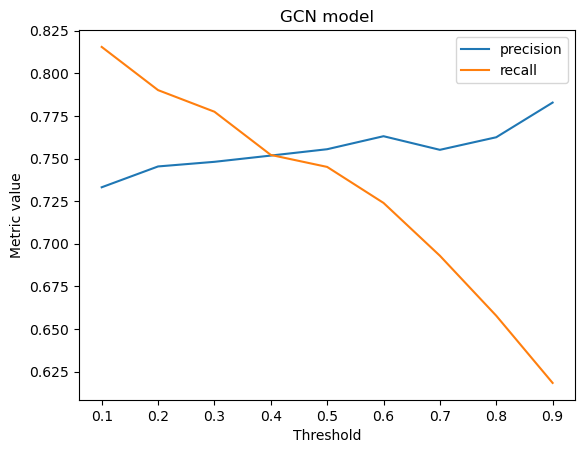

In [23]:
fig, ax = plt.subplots()

ax.plot(gcn_threshold_metrics_df["thresholds"], gcn_threshold_metrics_df["precision thresholds"], label = "precision")
ax.plot(gcn_threshold_metrics_df["thresholds"], gcn_threshold_metrics_df["recall thresholds"], label="recall")
ax.set_xlabel("Threshold")
ax.set_ylabel("Metric value")
ax.set_title("GCN model")
ax.legend()

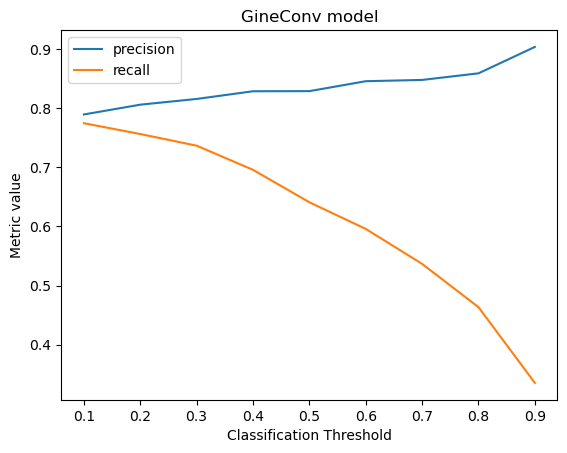

In [24]:
fig, ax = plt.subplots()

ax.plot(gineconv_threshold_metrics_df["thresholds"], gineconv_threshold_metrics_df["precision thresholds"], label = "precision")
ax.plot(gineconv_threshold_metrics_df["thresholds"], gineconv_threshold_metrics_df["recall thresholds"], label="recall")
ax.set_xlabel("Classification Threshold")
ax.set_ylabel("Metric value")
ax.set_title("GineConv model")
ax.legend()

/tmp/ipykernel_4718/2015068548.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


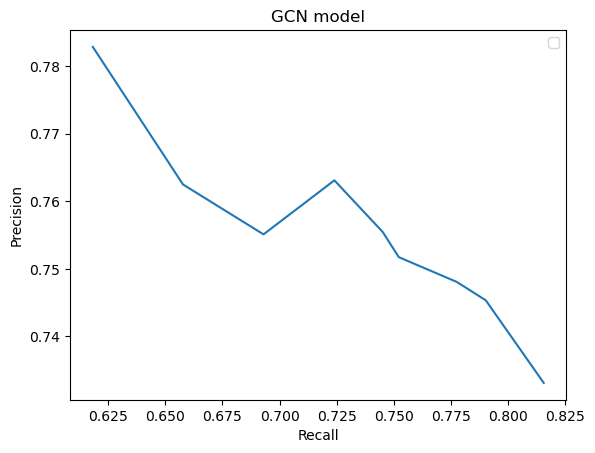

In [25]:
fig, ax = plt.subplots()

ax.plot(gcn_threshold_metrics_df["recall thresholds"], gcn_threshold_metrics_df["precision thresholds"])
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("GCN model")
ax.legend()

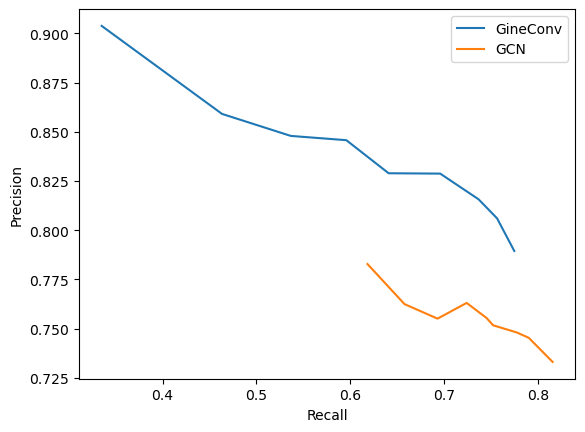

In [26]:
fig, ax = plt.subplots()

ax.plot(gineconv_threshold_metrics_df["recall thresholds"], gineconv_threshold_metrics_df["precision thresholds"], label = "GineConv")
ax.plot(gcn_threshold_metrics_df["recall thresholds"], gcn_threshold_metrics_df["precision thresholds"], label = "GCN")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()

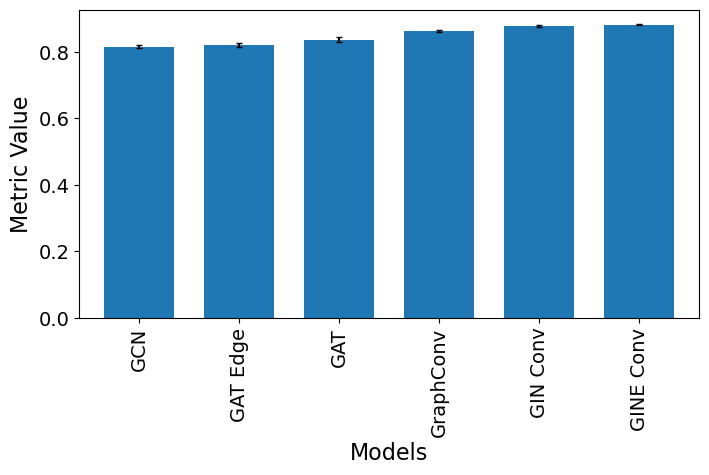

In [27]:
suffixes = {
        'auroc': "_auroc_df.pkl",
        'mean_train': "_mean_train_metrics.pkl",
        'mean_test': "_mean_test_metrics.pkl",
        'std_train': "_std_train_metrics.pkl",
        'std_test': "_std_test_metrics.pkl"
    }

models_metrics_df, models_metrics_error_df = plot_average_metrics(suffixes, 
    [bace_gcn_models_path, bace_gat_edge_models_path, bace_gat_models_path, bace_graphconv_models_path, 
    new_bace_ginconv_models_path, new_bace_gineconv_models_path],
    ["GCN", "GAT Edge", "GAT", "GraphConv","GIN Conv", "GINE Conv"],
     "auroc", bar_width = 0.7, show_legend = False, fontsize = 16, tick_labelsize = 14)



In [28]:
models_metrics_df

,GCN,GAT Edge,GAT,GraphConv,GIN Conv,GINE Conv
auroc,0.815405,0.820484,0.835579,0.862081,0.877198,0.880947
precision,0.751836,0.764298,0.764887,0.784244,0.802060,0.834829
recall,0.732394,0.753521,0.784507,0.792958,0.815493,0.673239
accuracy,0.761716,0.775578,0.784818,0.800000,0.819142,0.783498
f1-score,0.761144,0.775416,0.784651,0.799861,0.819207,0.779838
support,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000


In [29]:
models_metrics_error_df

,GCN,GAT Edge,GAT,GraphConv,GIN Conv,GINE Conv
auroc,0.004009,0.006233,0.007477,0.002386,0.001706,0.001341
precision,0.005864,0.006423,0.012077,0.009988,0.006710,0.009655
recall,0.030858,0.013728,0.018445,0.018445,0.007182,0.031225
accuracy,0.028524,0.015655,0.005423,0.008917,0.012437,0.018016
f1-score,0.013211,0.007053,0.002383,0.004014,0.005558,0.009392
support,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [30]:
# Load a random GINEConv model to try new_metric_func on 
torch.manual_seed(42)

new_bace_gineconv_models_path = bace_models_path / "new_gineconv_models"
model_save_path = new_bace_gineconv_models_path/"0_128_300_0.0001_global_mean_pool.pth"

loaded_model = MODIFIED_GINEConvClassifier(30, 128, 2, 3, global_mean_pool, True, 11)



if torch.cuda.is_available():
  loaded_model.load_state_dict(torch.load(f=model_save_path))
  loaded_model.eval()
else:
  loaded_model.load_state_dict(torch.load(f=model_save_path, map_location=torch.device('cpu')))
  loaded_model.eval()


loaded_model = loaded_model.to(device)

In [31]:
batch_size = 32
total_graph_embeddings = torch.empty([128, len(test_dataloader.dataset)])
class_labels = np.empty(len(test_dataloader.dataset))

for idx, batch in enumerate(test_dataloader):
    batch = batch.to(device)
    current_batch_size= len(batch)

    output, graph_embeddings = loaded_model(batch)

    total_graph_embeddings[:, idx * batch_size:idx * batch_size + current_batch_size] = graph_embeddings.T

    class_labels[idx * batch_size:idx * batch_size + current_batch_size] = batch.Class.cpu().detach().numpy()

In [32]:
total_graph_embeddings_array = total_graph_embeddings.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
graph_embeddings_2d = tsne.fit_transform(total_graph_embeddings_array.T)

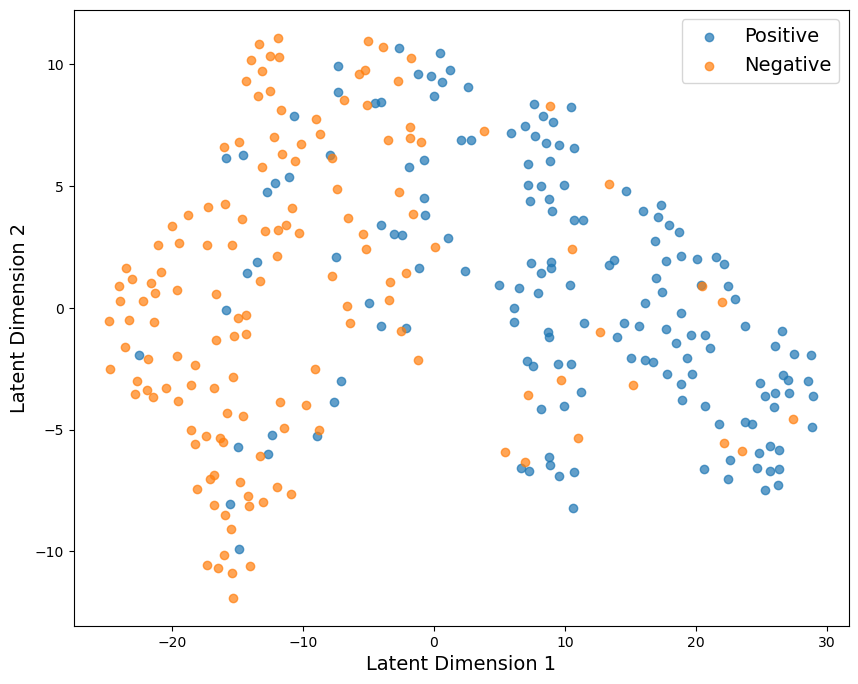

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
labels = ["Positive", "Negative"]
# Plot each class separately using the ax object
for idx, class_value in enumerate([0, 1]):  # Assuming binary classes: 0 and 1
    ax.scatter(
        graph_embeddings_2d[class_labels == class_value, 0],  # x-coordinates
        graph_embeddings_2d[class_labels == class_value, 1],  # y-coordinates
        alpha=0.7,
        label=f'{labels[idx]}'
    )

# Add title and legend using the ax object
# ax.set_title('t-SNE Visualisation of Graph Embeddings')
ax.set_xlabel("Latent Dimension 1", size=14)
ax.set_ylabel("Latent Dimension 2", size=14)
ax.legend(fontsize=14)

# Show the plot
plt.show()

In [34]:
# Load a random GCN model to try new_metric_func on 
bace_gcn_models_path =  bace_models_path / "gcn_models"
model_save_path = bace_gcn_models_path/"0_128_300_global_mean_pool.pth"

gcn_loaded_model = GCNClassifier(30, 128, 2, global_mean_pool)



if torch.cuda.is_available():
  gcn_loaded_model.load_state_dict(torch.load(f=model_save_path))
else:
  gcn_loaded_model.load_state_dict(torch.load(f=model_save_path, map_location=torch.device('cpu')))

In [35]:
gcn_total_params = sum(p.numel() for p in gcn_loaded_model.parameters())
print(f"Number of parameters: {gcn_total_params}")

Number of parameters: 37250


In [36]:
# Load a random GCN model to try new_metric_func on 
bace_gat_models_path =  bace_models_path / "gat_models"
model_save_path = bace_gat_models_path/"0_128_300_global_mean_pool.pth"

gat_loaded_model = GATClassifier(30, 128, 2, 4, global_mean_pool, False)



if torch.cuda.is_available():
  gat_loaded_model.load_state_dict(torch.load(f=model_save_path))
else:
  gat_loaded_model.load_state_dict(torch.load(f=model_save_path, map_location=torch.device('cpu')))

In [37]:
gat_total_params = sum(p.numel() for p in gat_loaded_model.parameters())
print(f"Number of parameters: {gat_total_params}")

Number of parameters: 346754


In [38]:
# Load a random GCN model to try new_metric_func on 
bace_gate_models_path =  bace_models_path / "gat_edge_models"
model_save_path = bace_gate_models_path/"0_128_300_global_mean_pool.pth"

gate_loaded_model = GATClassifier(30, 128, 2, 4, global_mean_pool, True)



if torch.cuda.is_available():
  gate_loaded_model.load_state_dict(torch.load(f=model_save_path))
else:
  gate_loaded_model.load_state_dict(torch.load(f=model_save_path, map_location=torch.device('cpu')))

In [39]:
gate_total_params = sum(p.numel() for p in gate_loaded_model.parameters())
print(f"Number of parameters: {gate_total_params}")

Number of parameters: 346754


In [40]:
# Load a random GCN model to try new_metric_func on 
bace_graphconv_models_path =  bace_models_path / "graphconv_models"
model_save_path = bace_graphconv_models_path/"0_128_300_global_mean_pool.pth"

graphconv_loaded_model = GraphConvClassifier(30, 128, 2, global_mean_pool)



if torch.cuda.is_available():
  graphconv_loaded_model.load_state_dict(torch.load(f=model_save_path))
else:
  graphconv_loaded_model.load_state_dict(torch.load(f=model_save_path, map_location=torch.device('cpu')))

In [41]:
graphconv_total_params = sum(p.numel() for p in graphconv_loaded_model.parameters())
print(f"Number of parameters: {graphconv_total_params}")

Number of parameters: 73858


In [42]:
# Load a random GCN model to try new_metric_func on 
bace_ginconv_models_path =  bace_models_path / "ginconv_models"
model_save_path = bace_ginconv_models_path/"0_128_300_global_mean_pool.pth"

ginconv_loaded_model = GINConvClassifier(30, 128, 2, 3, global_mean_pool)



if torch.cuda.is_available():
  ginconv_loaded_model.load_state_dict(torch.load(f=model_save_path))
else:
  ginconv_loaded_model.load_state_dict(torch.load(f=model_save_path, map_location=torch.device('cpu')))

In [43]:
ginconv_total_params = sum(p.numel() for p in ginconv_loaded_model.parameters())
print(f"Number of parameters: {ginconv_total_params}")

Number of parameters: 104066


In [44]:
# Load a random GCN model to try new_metric_func on 
bace_gineconv_models_path =  bace_models_path / "gineconv_models"
model_save_path = bace_gineconv_models_path/"0_128_300_global_mean_pool.pth"

gineconv_loaded_model = GINEConvClassifier(30, 128, 2, 3, global_mean_pool, True, 11)



if torch.cuda.is_available():
  gineconv_loaded_model.load_state_dict(torch.load(f=model_save_path))
else:
  gineconv_loaded_model.load_state_dict(torch.load(f=model_save_path, map_location=torch.device('cpu')))

In [45]:
gineconv_total_params = sum(p.numel() for p in gineconv_loaded_model.parameters())
print(f"Number of parameters: {gineconv_total_params}")

Number of parameters: 107498


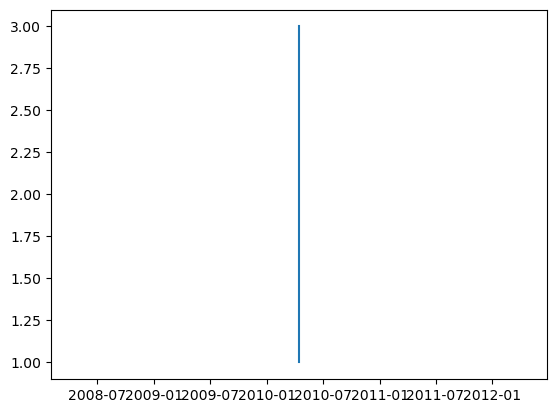

In [52]:
x = datetime.datetime(2010, 4, 14)
x
plt.plot([x,x,x], [1,2,3])

N-GramXGB
D-MPNN
PretrainGNN
ChemRL-GEM
Uni-Mol
MolXPT


Text(0, 0.5, 'AUC Score')

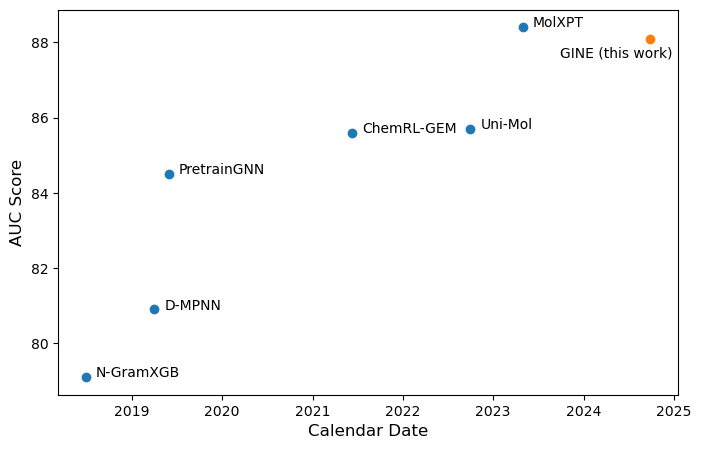

In [90]:
fig, ax = plt.subplots(figsize=(8, 5))
dates = [datetime.datetime(2018, 7, 1), datetime.datetime(2019, 4, 2), datetime.datetime(2019, 6, 1), datetime.datetime(2021, 6, 11), datetime.datetime(2022, 10, 1), datetime.datetime(2023, 5, 2)]
auc_scores = [79.1, 80.9, 84.5, 85.6, 85.7, 88.4]
ax.scatter(dates, auc_scores)
#ax.plot(dates, auc_scores)
ax.scatter(datetime.datetime(2024, 9, 25), 88.1,c = 'C1')

text = ["N-GramXGB", "D-MPNN", "PretrainGNN", "ChemRL-GEM", "Uni-Mol", 
        "MolXPT"] 
for i in range(0,len(dates)): 
    print(text[i])
    ax.annotate(text[i], (dates[i]+datetime.timedelta(days=+40), auc_scores[i])) 
ax.annotate("GINE (this work)", (dates[-1]+datetime.timedelta(days=+150), auc_scores[-1]-0.8))
ax.set_xlabel("Calendar Date", size=12)
ax.set_ylabel("AUC Score", size=12)